In [257]:
import pandas as pd
import wfdb
import numpy as np
import argparse
ekg_data = pd.read_csv('SUB_ICON_01010001_20210905_091338_ECG_AFIB_raw_250Hz.csv', header=None)
ekg_values = ekg_data.values[:,1] + 170
timestamps = ekg_data.values[:,0]
signals = np.array([ekg_values]).T

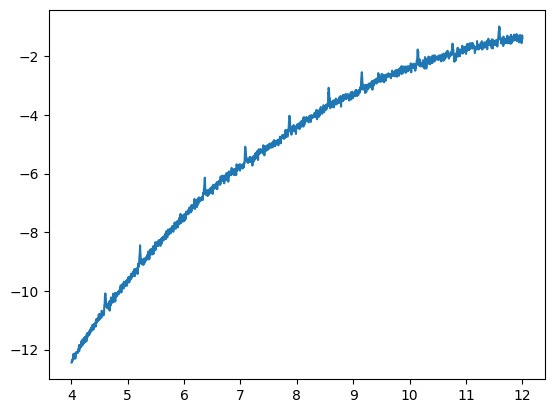

In [258]:
import matplotlib.pyplot as plt
plt.plot(timestamps[1000:3000], ekg_values[1000:3000])

[comments]
* find baseline issue above
* need to apply bandpass filter

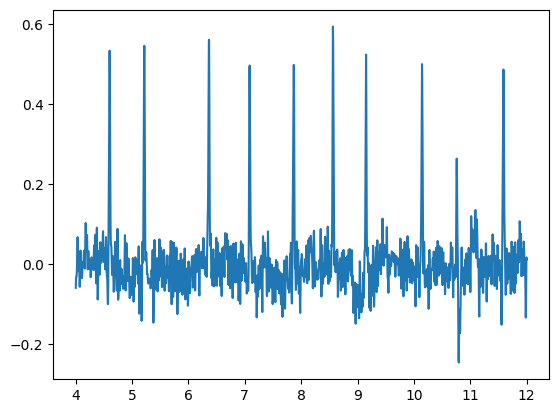

In [259]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Define the filter parameters
fs = 250  # Sampling frequency (Hz)
lowcut = 0.5  # Low cutoff frequency (Hz)
highcut = 50  # High cutoff frequency (Hz)
order = 4  # Filter order

# Normalize the cutoff frequencies
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

# Design the low-pass filter
b, a = butter(order, [low, high], btype='band', analog=False)

# Apply the filter to the EKG signal
filtered_ekg = filtfilt(b, a, ekg_values)
plt.plot(timestamps[1000:3000], filtered_ekg[1000:3000])

[comments]
* baseline noise still exist
* apply notched filter (fail)

In [260]:
'''notched filter, fail
import numpy as np
from scipy.signal import kaiserord, lfilter, firwin
import matplotlib.pyplot as plt

# Define the filter parameters
fs = 250  # Sampling frequency (Hz)
notch_freq = 10  # Notch frequency (Hz)
notch_width = 1  # Notch width (Hz)
ripple_db = 8  # Ripple outside the passband (dB)

# Compute the Kaiser window parameters
nyquist_rate = fs / 2.0
width = notch_width / nyquist_rate
N, beta = kaiserord(ripple_db, width)

# Adjust the filter order to be odd
if N % 2 == 0:
    N += 1

# Compute the coefficients of the notch filter
taps = firwin(N, [notch_freq - notch_width / 2, notch_freq + notch_width / 2],
              window=('kaiser', beta), pass_zero='bandstop', fs=fs)

# Apply the notch filter to the EKG signal
notched_ekg = lfilter(taps, 1.0, filtered_ekg)
'''

"notched filter, fail\nimport numpy as np\nfrom scipy.signal import kaiserord, lfilter, firwin\nimport matplotlib.pyplot as plt\n\n# Define the filter parameters\nfs = 250  # Sampling frequency (Hz)\nnotch_freq = 10  # Notch frequency (Hz)\nnotch_width = 1  # Notch width (Hz)\nripple_db = 8  # Ripple outside the passband (dB)\n\n# Compute the Kaiser window parameters\nnyquist_rate = fs / 2.0\nwidth = notch_width / nyquist_rate\nN, beta = kaiserord(ripple_db, width)\n\n# Adjust the filter order to be odd\nif N % 2 == 0:\n    N += 1\n\n# Compute the coefficients of the notch filter\ntaps = firwin(N, [notch_freq - notch_width / 2, notch_freq + notch_width / 2],\n              window=('kaiser', beta), pass_zero='bandstop', fs=fs)\n\n# Apply the notch filter to the EKG signal\nnotched_ekg = lfilter(taps, 1.0, filtered_ekg)\n"

[comments]
* apply arma, but fail

In [245]:
'''general arma, fail 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit an ARMA model to the filtered EKG signal
model = ARIMA(filtered_ekg, order=(5, 0, 3))  # Specify the AR and MA orders
model_fit = model.fit()

# Get the residuals (remaining noise) from the ARMA model
residuals = model_fit.resid

# Subtract the residuals from the filtered EKG signal to remove the remaining noise
denoised_ekg = filtered_ekg - residuals

# Plot the original, filtered, and denoised EKG signals
plt.figure(figsize=(10, 4))
plt.plot(timestamps[500:2000], filtered_ekg[500:2000], label='Filtered EKG')
plt.plot(timestamps[500:2000], denoised_ekg[500:2000], label='Denoised EKG (ARMA)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()
'''

"general arma, fail \nfrom statsmodels.tsa.arima.model import ARIMA\nimport matplotlib.pyplot as plt\n\n# Fit an ARMA model to the filtered EKG signal\nmodel = ARIMA(filtered_ekg, order=(5, 0, 3))  # Specify the AR and MA orders\nmodel_fit = model.fit()\n\n# Get the residuals (remaining noise) from the ARMA model\nresiduals = model_fit.resid\n\n# Subtract the residuals from the filtered EKG signal to remove the remaining noise\ndenoised_ekg = filtered_ekg - residuals\n\n# Plot the original, filtered, and denoised EKG signals\nplt.figure(figsize=(10, 4))\nplt.plot(timestamps[500:2000], filtered_ekg[500:2000], label='Filtered EKG')\nplt.plot(timestamps[500:2000], denoised_ekg[500:2000], label='Denoised EKG (ARMA)')\nplt.xlabel('Time (s)')\nplt.ylabel('Amplitude')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

[comments]
* apply simple moving average
* baseline noise is removed, but qrs also affected.

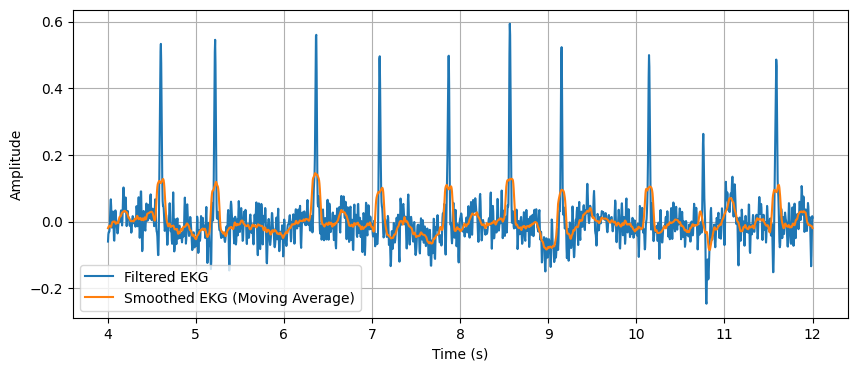

In [261]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(signal, window_size):
    """
    Applies moving average smoothing to the input signal.
    """
    window = np.ones(window_size) / window_size
    return np.convolve(signal, window, mode='same')

# Apply moving average to the filtered EKG signal
window_size = 25  # Adjust the window size as needed
smoothed_ekg = moving_average(filtered_ekg, window_size)

# Plot the original, filtered, and smoothed EKG signals
plt.figure(figsize=(10, 4))
plt.plot(timestamps[1000:3000], filtered_ekg[1000:3000], label='Filtered EKG')
plt.plot(timestamps[1000:3000], smoothed_ekg[1000:3000], label='Smoothed EKG (Moving Average)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

[comments]
* try to merge smoothed ekg and filtered ekg

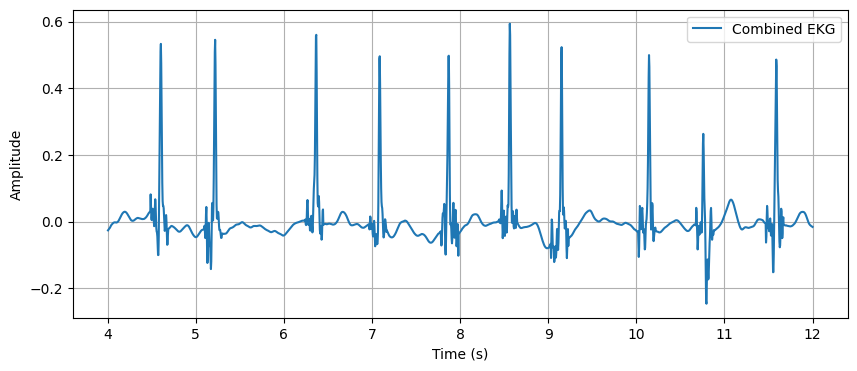

In [251]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt, find_peaks

def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def pan_tompkins_qrs_detect(signal, fs):
    # Bandpass filter
    filtered_signal = bandpass_filter(signal, 5, 15, fs)

    # Differentiation
    diff_signal = np.diff(filtered_signal)

    # Squaring
    squared_signal = diff_signal ** 2

    # Moving average
    window_size = int(0.12 * fs)  # 120 ms window
    averaged_signal = np.convolve(squared_signal, np.ones(window_size) / window_size, mode='same')

    # Thresholding
    threshold = np.mean(averaged_signal) * 0.5  # Adjust the threshold as needed
    peaks, _ = find_peaks(averaged_signal, height=threshold, distance=int(0.2 * fs))  # 200 ms minimum distance

    return peaks

# Detect QRS complexes using Pan-Tompkins algorithm
qrs_peaks = pan_tompkins_qrs_detect(filtered_ekg, fs)

# Combine the baseline from the moving average signal with the peak area from the original signal
combined_ekg = smoothed_ekg.copy()
for peak in qrs_peaks:
    start = max(0, peak - int(0.1 * fs))  # 100 ms before the peak
    end = min(len(filtered_ekg), peak + int(0.1 * fs))  # 100 ms after the peak => TODO: check the interaction, and identify QS more accurately !
    combined_ekg[start:end] = filtered_ekg[start:end]

# Plot the original, smoothed, and combined EKG signals
plt.figure(figsize=(10, 4))
plt.plot(timestamps[1000:3000], combined_ekg[1000:3000], label='Combined EKG')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

[comments]
* qrs location is not accurate. some issue on merging boundary.
* apply moving average to mitigate the issue

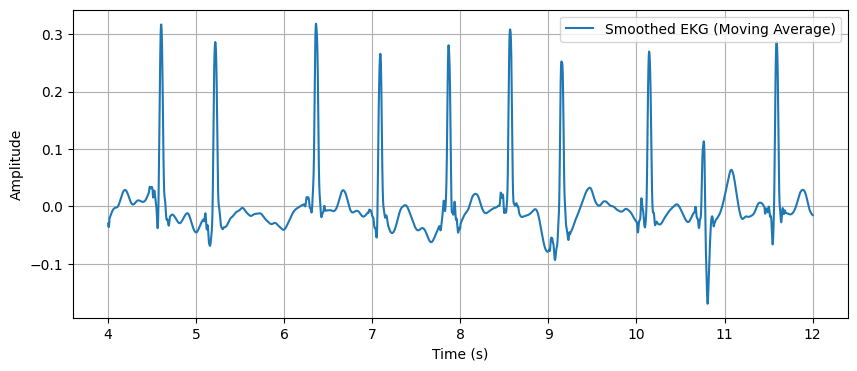

In [262]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(signal, window_size):
    """
    Applies moving average smoothing to the input signal.
    """
    window = np.ones(window_size) / window_size
    return np.convolve(signal, window, mode='same')

# Apply moving average to the filtered EKG signal
window_size = 10  # Adjust the window size as needed
smoothed_ekg = moving_average(combined_ekg, window_size)

# Plot the original, filtered, and smoothed EKG signals
plt.figure(figsize=(10, 4))
plt.plot(timestamps[1000:3000], smoothed_ekg[1000:3000], label='Smoothed EKG (Moving Average)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()